# DATASET:
https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset

In [16]:
!pip install -q silence_tensorflow

  Preparing metadata (setup.py) ... done


In [17]:
#a libraries to avoid keras and tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

#libraries to avoid other warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [18]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from PIL import Image
import tensorflow as tf
import keras

In [19]:
# Call a function to better plot visualizations
sns.set_style('darkgrid')

# Loading Data

In [58]:
#location of main dataset
base_dir="/content/drive/MyDrive/Project"

#show main directory containers
os.listdir(base_dir)

['train']

In [59]:
# Define train folder pathes.
train_dir = os.path.join(base_dir, 'train')

In [60]:
# Count number of folders in train directory as number of classes.
# Number of classes
classes = os.listdir(train_dir)
num_classes = len(classes)

# Count Plot

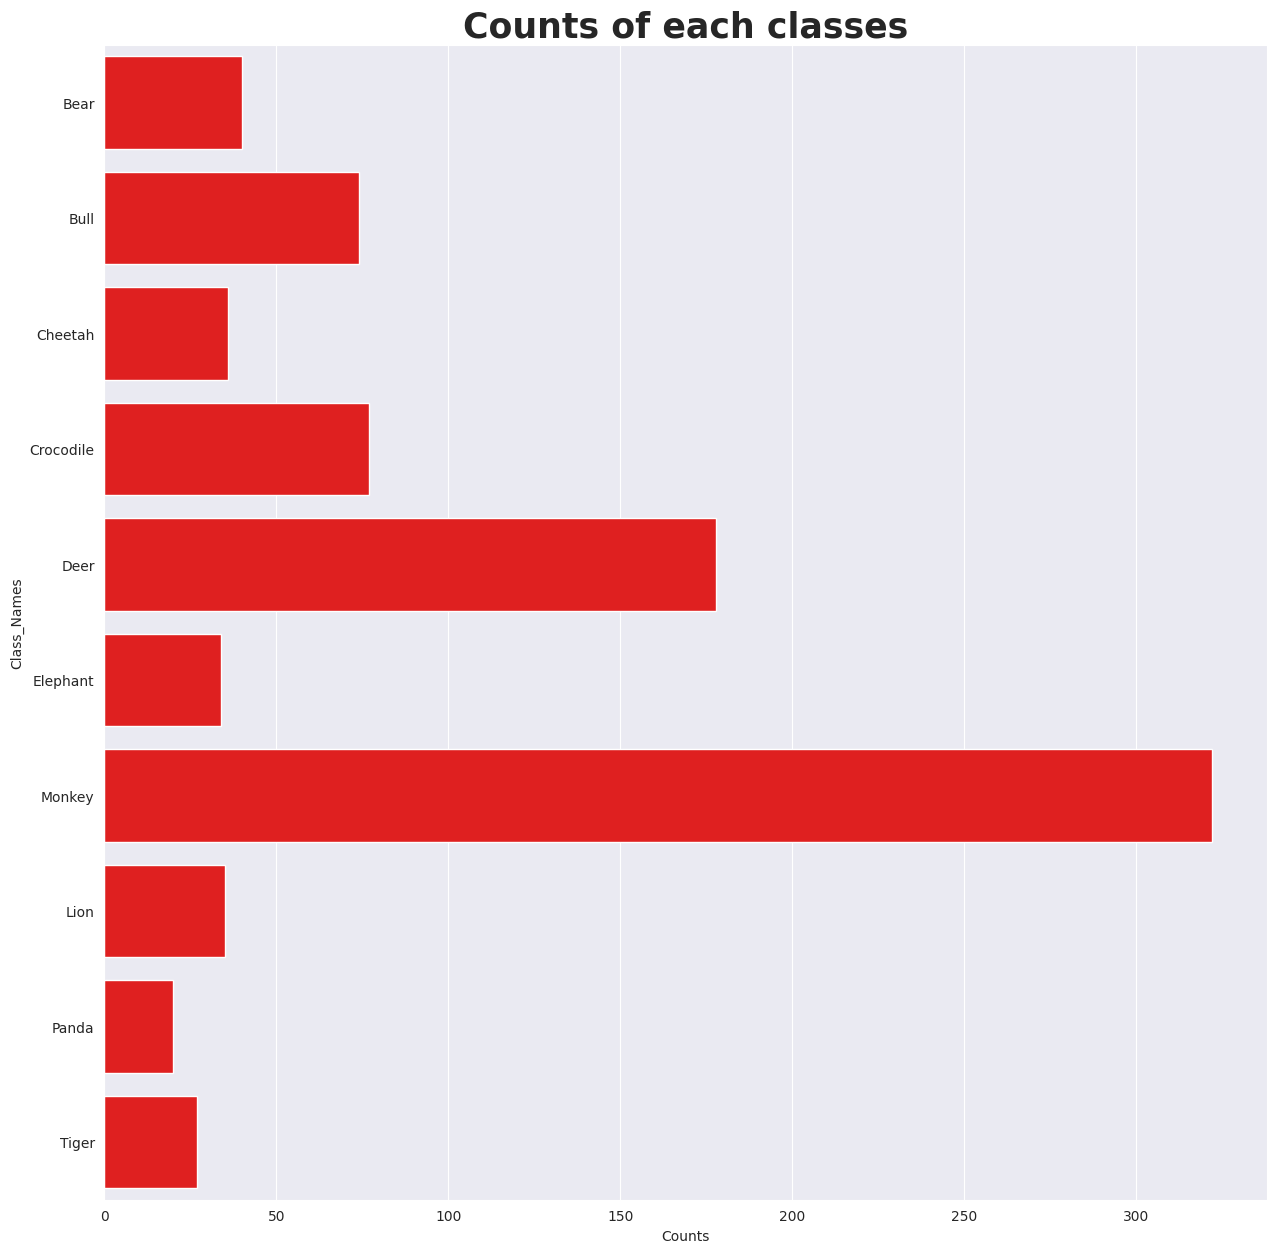

In [61]:
# A variable to store number of images in each class and class names.
counts = []

# Loop over classes
for class_name in classes :
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    counts.append((class_name, count))

# Convert variable to DataFrame
counts = pd.DataFrame(counts, columns=['Class_Names', 'Counts'])
# Plot the DataFrame
plt.figure(figsize=(15, 15))
ax = sns.barplot(data=counts, y='Class_Names', x='Counts',color="red")
ax.set_title('Counts of each classes', fontsize=25, fontweight='bold')

plt.show()


# Image Show

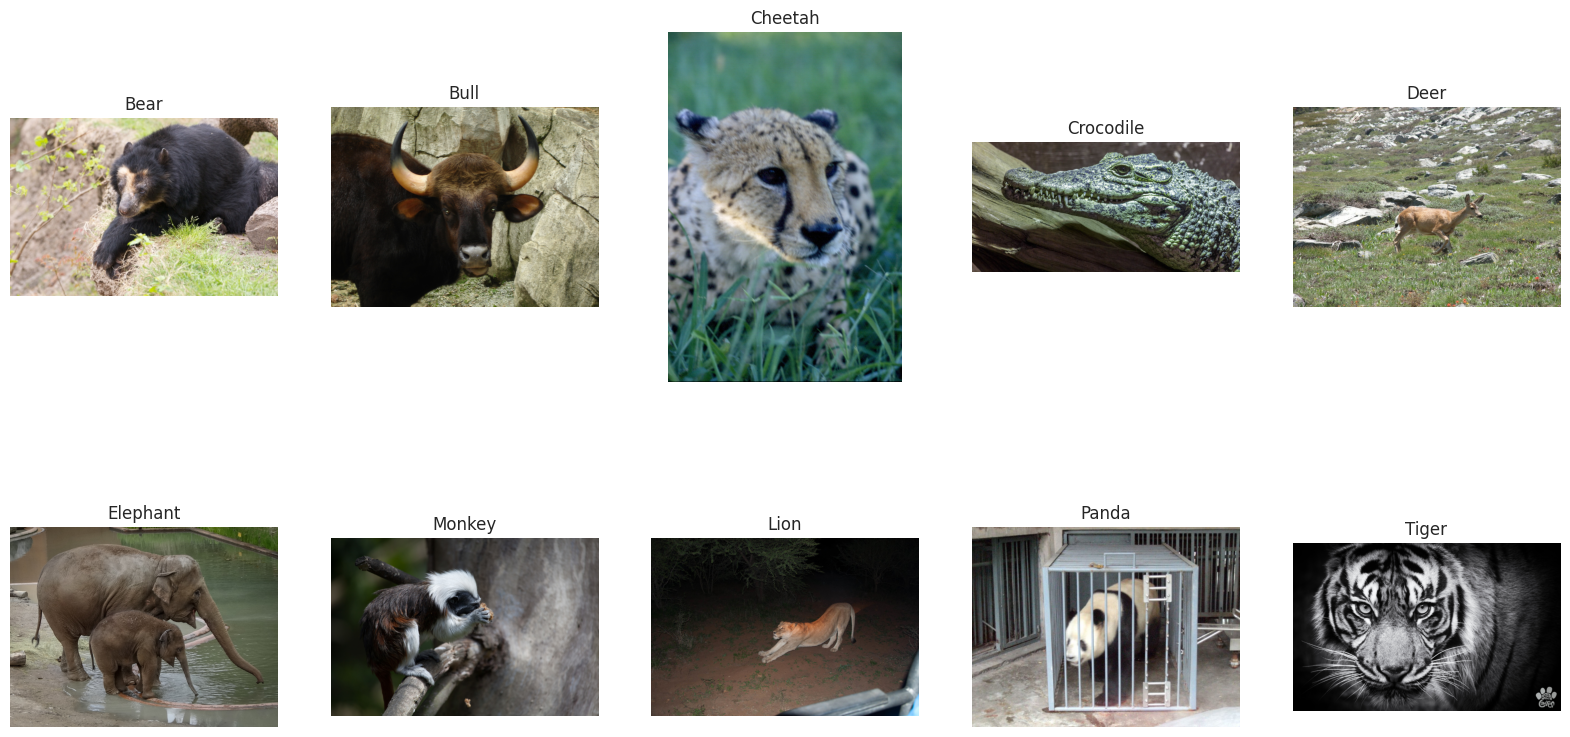

In [62]:
# Define base plot size
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

# Loop over classes
for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(train_dir, class_name)
    img = [file for file in os.listdir(class_path) if file.endswith('.jpg')]
    img = os.path.join(class_path, img[0])
    img = Image.open(img)

    # ✅ Calculate row & column index correctly
    row = i // 5  # Integer division to get row index
    col = i % 5   # Modulo to get column index

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

# ✅ Hide any empty subplots (adjust if needed)
for j in range(len(classes), 2 * 5):
    row = j // 5
    col = j % 5
    ax[row, col].axis('off')

plt.show()


# Data Preprocessing

In [63]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_full = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

Found 833 files belonging to 10 classes.


# Splitting

In [64]:
# Shuffle dataset
train_full = train_full.shuffle(256).prefetch(tf.data.AUTOTUNE)

In [65]:
num_all_batches = train_full.cardinality().numpy()
print(colored(f'Number of all Batches : {num_all_batches}', 'white', 'on_blue', attrs=['bold']))


Number of all Batches : 27


In [66]:
num_train_batches = int(num_all_batches * 0.8)  # 80% for training
num_valid_batches = num_all_batches - num_train_batches  # Remaining for validation

# Print the TARGET : number of batches for train and validation dataset
print(colored(' Target : ', 'green', attrs=['bold']))
print('-' * 35)
print(colored(f'Number of Train batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_batches}', 'blue', attrs=['bold']))

 Target : 
-----------------------------------
Number of Train batches : 21
Number of Validation batches : 6


In [67]:
# Split the dataset into training and validation
train_ds = train_full.take(num_train_batches)

remain = train_full.skip(num_train_batches)

valid_ds = remain.take(num_valid_batches)

# Print number of batches in train and validation datasets after split
print(colored(f'Number of train batches : {len(list(train_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of valid batches : {len(list(valid_ds))}', 'green', attrs=['bold']))

Number of train batches : 21
Number of valid batches : 6


# Creating Model

## Pretrained Model




In [31]:
from tensorflow import keras

In [68]:
# Load VGG19 pretrained model with imagenet weights
pretrained_model = keras.applications.VGG19(
    weights='imagenet', input_shape=(224, 224, 3), include_top=False
)

In [69]:
# Show information of ResNet50V2 layers
pretrained_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

## Freeze Pretrained Model Layers

In [70]:
# Print all the layer's name in ResNet50V2
for layer in pretrained_model.layers :
    print(layer.name)

input_layer_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [71]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pretrained_model.trainable = True                # Whole model is trainable
set_trainable = False                            # Set a flag to False

for layer in pretrained_model.layers :           # A loop over model's layers
    if layer.name == 'block5_conv1' :            # Define target layer's name (with if condition)
        set_trainable = True                     # Change flag value to True
    if set_trainable :                           # A condition for True flag
        layer.trainable = True                   # Set layer trainablity to True
    else :                                       # else condition
        layer.trainable = False                  # For layers befor our target layer

In [72]:
# Add custom layers on top of the base model
model = keras.models.Sequential()
model.add(pretrained_model)                               # At first add our pre-trained model
model.add(keras.layers.Dropout(0.5))                      # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.GlobalAveragePooling2D())          # Apply GlobalAveragePooling2D
model.add(keras.layers.Flatten())                         # Convert the output to 1D arraay
model.add(keras.layers.Dense(1024, activation='relu'))    # Add a Dense layer with 1024 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                      # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(512, activation='relu'))     # Add a Dense layer with 512 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                      # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(10, activation='softmax'))   # Add a Dense layer with number fo classes neuron as output with activation='softmax'
best_model = model

# Callbacks

In [73]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = keras.callbacks.ModelCheckpoint('animal_detection_model.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,min_lr=1e-6)

# Compile The Mode

In [74]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train The Model

In [75]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=100,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - accuracy: 0.1254 - loss: 5.4229 - val_accuracy: 0.3281 - val_loss: 1.9682 - learning_rate: 1.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.3336 - loss: 2.0173 - val_accuracy: 0.3913 - val_loss: 1.6931 - learning_rate: 1.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4084 - loss: 1.7656 - val_accuracy: 0.4635 - val_loss: 1.6984 - learning_rate: 1.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4562 - loss: 1.7244 - val_accuracy: 0.4224 - val_loss: 1.7023 - learning_rate: 1.0000e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.4445 - loss: 1.7363 - val_accuracy: 0.5104 - val_loss: 1.6349 - learning_rate: 1.0000e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4844 - loss: 1.6506 - val_accuracy: 0.4286 - val_loss: 1.7315 - learning_rate: 1.0000e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - ac

In [76]:
# Save the trained model (after training is finished)
model.save("animal_detection_model.keras")  # Saves as a Keras model

In [77]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
56,0.98752,0.034554,1.000000,0.006835,0.000012
57,0.99220,0.026620,1.000000,0.007493,0.000006
58,0.99376,0.022269,0.994792,0.008858,0.000006
59,0.99064,0.030784,0.993789,0.012033,0.000006
60,0.99532,0.021585,1.000000,0.002864,0.000003


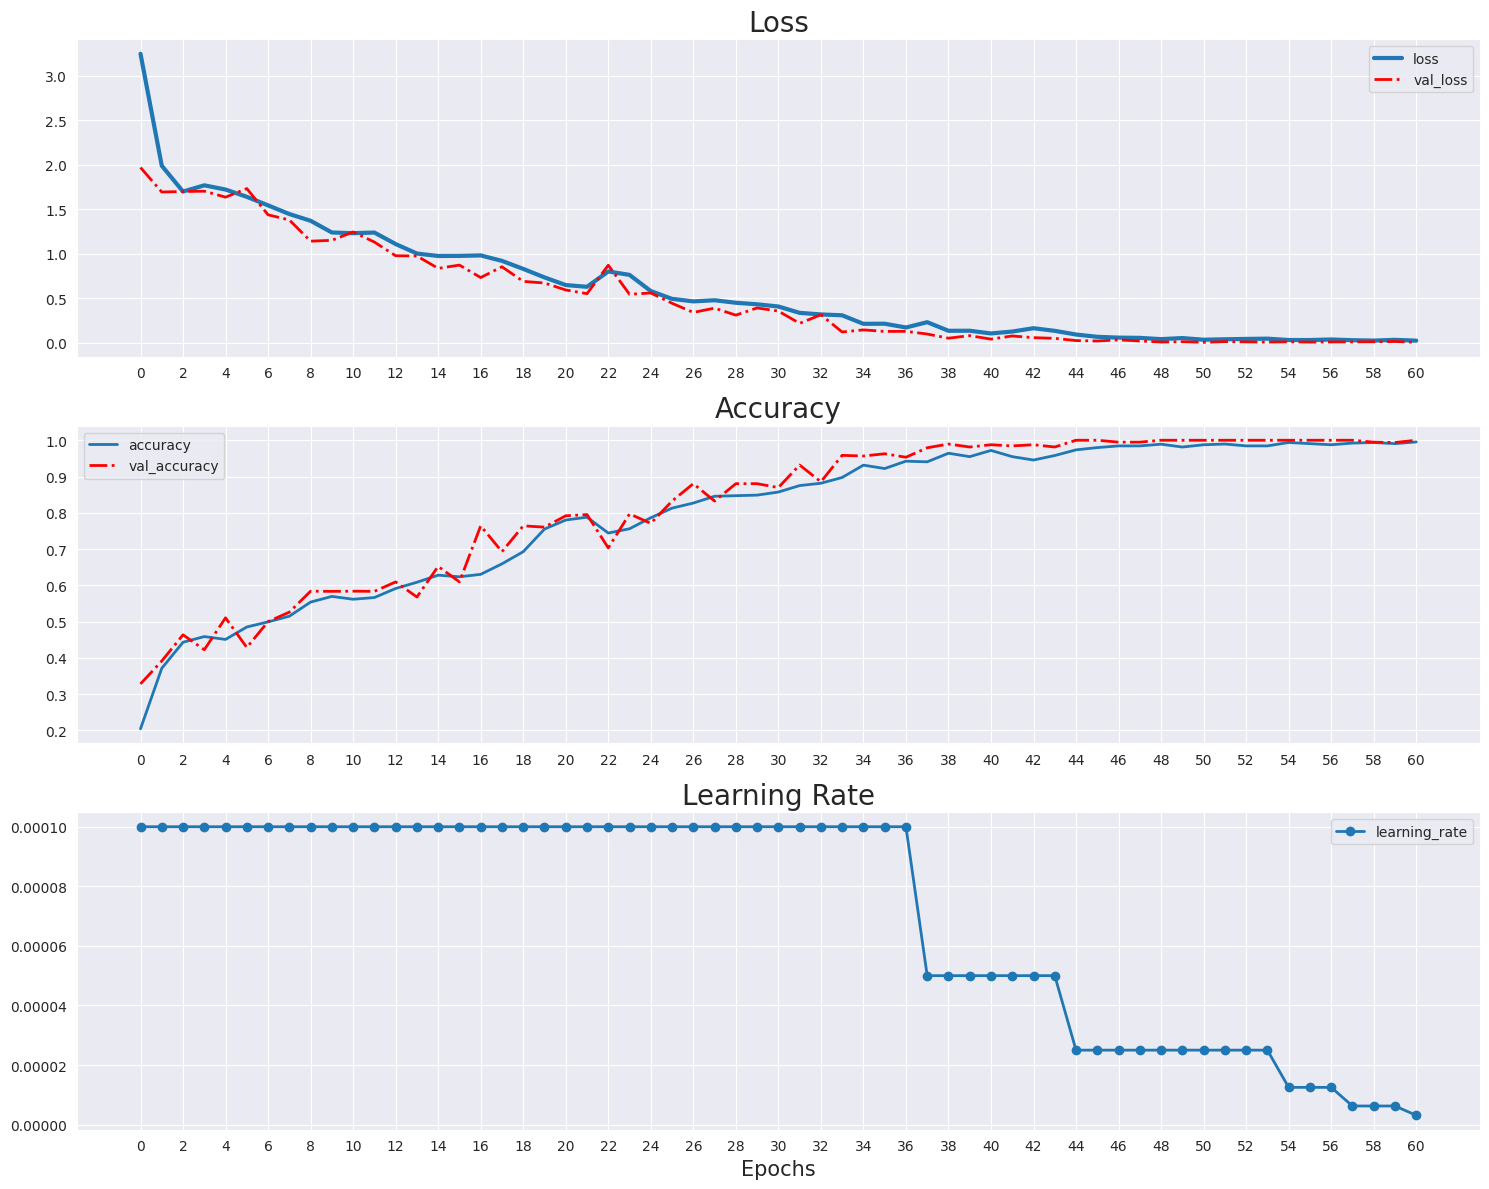

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Define a X variable to store range of epochs (Assuming 'result_df' contains the training history)
x = np.arange(len(result_df))

# Create a plot with 3 rows and 1 column with size of (15, 12)
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# AX0: Plot Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

# AX1: Plot Accuracy
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# AX2: Plot Learning Rate
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
ax[2].set_title('Learning Rate', fontsize=20)
ax[2].set_xlabel('Epochs', fontsize=15)
ax[2].set_xticks(np.arange(0, len(x), 2))
ax[2].legend()

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots for better visualization
plt.show()


# Evaluation

In [79]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
best_model = keras.models.load_model('/content/drive/MyDrive/animal_detection_model.keras')

In [80]:
# Evaluate the model on training data
loss, accuracy = best_model.evaluate(train_ds)
print(f'Loss on train data: {loss}')
print(f'Accuracy on train data: {accuracy * 100}%')


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9996 - loss: 0.0040
Loss on train data: 0.00574067048728466
Accuracy on train data: 99.85119104385376%


In [81]:
# Evaluate the model on validation data
loss, accuracy = best_model.evaluate(valid_ds)
print(f'Loss on validation data: {loss}')
print(f'Accuracy on validation data: {accuracy * 100}%')


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0046
Loss on validation data: 0.007149506360292435
Accuracy on validation data: 100.0%


In [95]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

# Load the trained model i.e Load the trained model (NO TRAINING, JUST LOADING,no epoch running)
best_model = tf.keras.models.load_model("/content/drive/MyDrive/animal_detection_model.keras")

# Directly set the class names if you know them or were previously defined
# If you have 36 classes:
class_names =['Bear', 'Bull', 'Cheetah', 'Crocodile', 'Deer',
                'Elephant','Lion','Monkey','Panda','Tiger']  # List your class names here

# Alternatively, you can get the class names from the training directory
# Make sure this matches your train dataset's structure
# For example, using os.listdir() to get the folder names in the training directory
import os
train_dir = "/content/drive/MyDrive/Project/train"  # Replace with your actual train directory path
class_names = sorted(os.listdir(train_dir))  # Assuming folder names represent class names

# Load and preprocess the image
img_path = "/content/drive/MyDrive/deer.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # Resize image
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Apply VGG19 preprocessing

# Make a prediction
predictions = best_model.predict(img_array)

# Get the predicted class index
predicted_class = np.argmax(predictions)  # Index of highest probability

# Print prediction confidence scores
print("\nPrediction Confidence Scores:")
for i, prob in enumerate(predictions[0]):
    print(f"{class_names[i]}: {prob*100:.2f}%")

# Print final predicted class
print(f"\nFinal Predicted Class: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step

Prediction Confidence Scores:
Bear: 0.00%
Bull: 0.00%
Cheetah: 0.00%
Crocodile: 0.00%
Deer: 100.00%
Elephant: 0.00%
Lion: 0.00%
Monkey: 0.00%
Panda: 0.00%
Tiger: 0.00%

Final Predicted Class: Deer
